## Nonlinear pulse propagation

From Hamerly's paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
os.chdir(cwd)

## Units
We'll work in the following units:

time = ps <br>
frequency = THz (1/time) <br>
distance = mm

In [2]:
from scipy.constants import pi, c
c = c*1e-9; #mm/ps, [Freq]=THz

In [3]:
#Input parameters
la = 1.5 #um
lb = la/2 #um
L = 40 #mm
alpha = 0.00691 #1/mm
u = 0.329 #ps/mm
Tp = 13.2 #ps
b2a = 1.12e-4 #ps^2/mm
b3a = 3.09e-5 #ps^3/mm
b2b = 4.06e-4
b3b = 2.51e-5
epsilon = 5.16e-5 #ps^0.5/mm
G0 = 3.33
b0 = 3.84e2 #ps^0.5 !?
a0 = 10

p = 1.1 #normalized power
l = 0 #detuning


### Pump

Gaussian pulse:
$$A(t) = exp(-t^2/t_p^2)$$

$$t_p = \frac{t_d}{\sqrt{4 \log{2}}}$$

Sampling Rate = 0.2580645161290249 ps


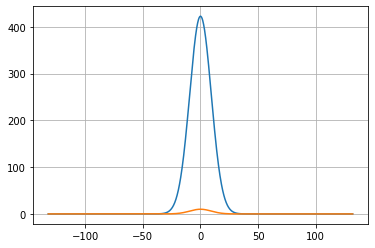

In [7]:
#tp = td/np.sqrt(4*np.log(2)) #tp for Gaussian pulse

N = 1024 #Fourier size
t = np.linspace(-10*Tp, 10*Tp, N)
ts = t[1]-t[0] #Sampling period
print('Sampling Rate =',ts, 'ps')
Omega = np.fft.fftfreq(t.size, ts)

b = p*b0*np.exp(-t**2/Tp**2)
a = a0*np.exp(-t**2/Tp**2)

plt.plot(t,b,t,a)
plt.grid()

### Propagation

In [5]:
h = 0.1 #Distance step Size

#Linear operator (Waveguide)
Da = np.exp((-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)*h)
Db = np.exp((-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)*h)

Da = np.fft.fftshift(Da)
Db = np.fft.fftshift(Db)

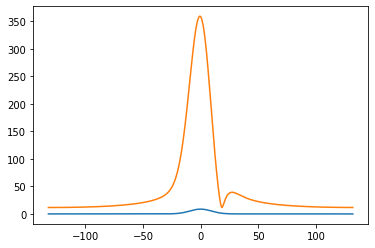

In [9]:
zi = 0

b = p*b0*np.exp(-t**2/Tp**2)
a = a0*np.exp(-t**2/Tp**2)

while zi<L:
    #Linear half step
    A = np.fft.fft(a)
    A = A*Da
    a = np.fft.ifft(A)
    
    B = np.fft.fft(b)
    B = B*Db
    b = np.fft.ifft(B)
    
    #Nonlinear step
    #az = az + k*np.conj(az)
    
    #Second Linear half step
    
    #Next z
    zi = zi+h
    
plt.plot(t, abs(a), t, abs(b));